<a href="https://colab.research.google.com/github/shreyasudaya/Boundary-Unlearning/blob/master/unlearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# # Step 1: Install and import necessary libraries
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision
# import torchvision.transforms as transforms
# from torchvision import datasets, models
# import time

# # Step 2: Set device configuration (GPU if available)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Step 3: Download and preprocess the CIFAR-100 dataset
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, padding=4),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
# ])

# # Download the CIFAR-100 dataset
# train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
# test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# # Step 4: Create DataLoader for batching and shuffling
# batch_size = 128
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# # Step 5: Load a pre-trained ResNet model and modify it for CIFAR-100
# model = models.resnet18(pretrained=True)  # You can also use resnet34 or resnet50
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 100)  # Modify the final layer to match CIFAR-100 classes
# model = model.to(device)

# # Step 6: Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Step 7: Train the model
# def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
#     model.train()
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         correct = 0
#         total = 0
#         start_time = time.time()

#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             _, predicted = outputs.max(1)
#             total += labels.size(0)
#             correct += predicted.eq(labels).sum().item()

#         end_time = time.time()
#         epoch_loss = running_loss / len(train_loader)
#         accuracy = 100. * correct / total
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {end_time - start_time:.2f}s")

# # Step 8: Train the model for a specific number of epochs
# train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# # Step 9: Evaluate the model on the test set
# def evaluate_model(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, predicted = outputs.max(1)
#             total += labels.size(0)
#             correct += predicted.eq(labels).sum().item()

#     accuracy = 100. * correct / total
#     print(f'Test Accuracy: {accuracy:.2f}%')

# evaluate_model(model, test_loader)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import copy
import numpy as np
from torchvision.models import resnet18

In [10]:

def load_data(batch_size):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Split trainset into retain and forget subsets
    train_retain_size = int(len(trainset) * 0.9)
    train_forget_size = len(trainset) - train_retain_size

    retain_dataset, forget_dataset = random_split(trainset, [train_retain_size, train_forget_size])

    retain_loader = DataLoader(retain_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    forget_loader = DataLoader(forget_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return retain_loader, forget_loader, test_loader



In [11]:
# ResNet model setup
def get_model():
    model = resnet18(num_classes=100)
    return model

def likelihood(score, mean, var):
    nll = -(((score - mean)**2) / (2 * (var ** 2))) - 0.5 * torch.log(var ** 2) - 0.5 * torch.log(4 * torch.acos(torch.zeros(1)))
    return torch.exp(nll)



In [12]:
def get_salun_mask(model, device, forget_loader, threshold=0.1):
    mask = {}
    for name, param in model.named_parameters():
        mask[name] = 0

    model.train()
    for data, target in forget_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target, reduction='sum')
        loss.backward()
        with torch.no_grad():
            for name, param in model.named_parameters():
                if param.grad is not None:
                    mask[name] += param.grad.data

    with torch.no_grad():
        for name in mask:
            mask[name] = torch.abs_(mask[name])

    sorted_dict_positions = {}
    hard_dict = {}

    # Concatenate all tensors into a single tensor
    all_elements = -torch.cat([tensor.flatten() for tensor in mask.values()])
    threshold_index = int(len(all_elements) * threshold)

    positions = torch.argsort(all_elements)
    ranks = torch.argsort(positions)

    start_index = 0
    for key, tensor in mask.items():
        num_elements = tensor.numel()
        tensor_ranks = ranks[start_index : start_index + num_elements]
        sorted_positions = tensor_ranks.reshape(tensor.shape)
        sorted_dict_positions[key] = sorted_positions

        threshold_tensor = torch.zeros_like(tensor_ranks)
        threshold_tensor[tensor_ranks < threshold_index] = 1
        threshold_tensor = threshold_tensor.reshape(tensor.shape)
        hard_dict[key] = threshold_tensor
        start_index += num_elements

    return hard_dict

In [13]:


# Train function with SALUN unlearning
def salun_train(args, model, device, retain_loader, forget_loader, test_loader, optimizer, epochs, batch_size):
    mask = get_salun_mask(model, device, forget_loader, threshold=args.salun_threshold)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data, target in retain_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = F.cross_entropy(outputs, target)
            loss.backward()

            # Apply the mask to the gradients
            if mask:
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        param.grad *= mask[name]

            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(retain_loader)}")

    # Test the model after unlearning
    test(model, device, test_loader)

# Testing function
def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    print(f'Test Accuracy: {100 * correct / total} %')

# Main execution
if __name__ == "__main__":
    class Args:
        salun_threshold = 0.1
        batch_size = 128
        lr = 0.1
        epochs = 10
        momentum = 0.9
        weight_decay = 1e-4

    args = Args()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    retain_loader, forget_loader, test_loader = load_data(batch_size=args.batch_size)
    model = get_model().to(device)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    # Train the model with SALUN unlearning
    salun_train(args, model, device, retain_loader, forget_loader, test_loader, optimizer, epochs=args.epochs, batch_size=args.batch_size)


100%|██████████| 170498071/170498071 [00:02<00:00, 72968622.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10], Loss: 2.3724263330752198
Epoch [2/10], Loss: 1.6246497085825964
Epoch [3/10], Loss: 1.4239645715464244
Epoch [4/10], Loss: 1.2978979223831133
Epoch [5/10], Loss: 1.175824600695209
Epoch [6/10], Loss: 1.0900118858976797
Epoch [7/10], Loss: 1.021635575727983
Epoch [8/10], Loss: 0.9539693648164923
Epoch [9/10], Loss: 0.9179781788790767
Epoch [10/10], Loss: 0.8696315175091679
Test Accuracy: 66.63 %


----------------------------------------
Generating Dataset
----------------------------------------


Test class 3: 100%|██████████| 1000/1000 [00:00<00:00, 16814.27it/s]
<ipython-input-16-d7c01dbc9d93>:248: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-talk")


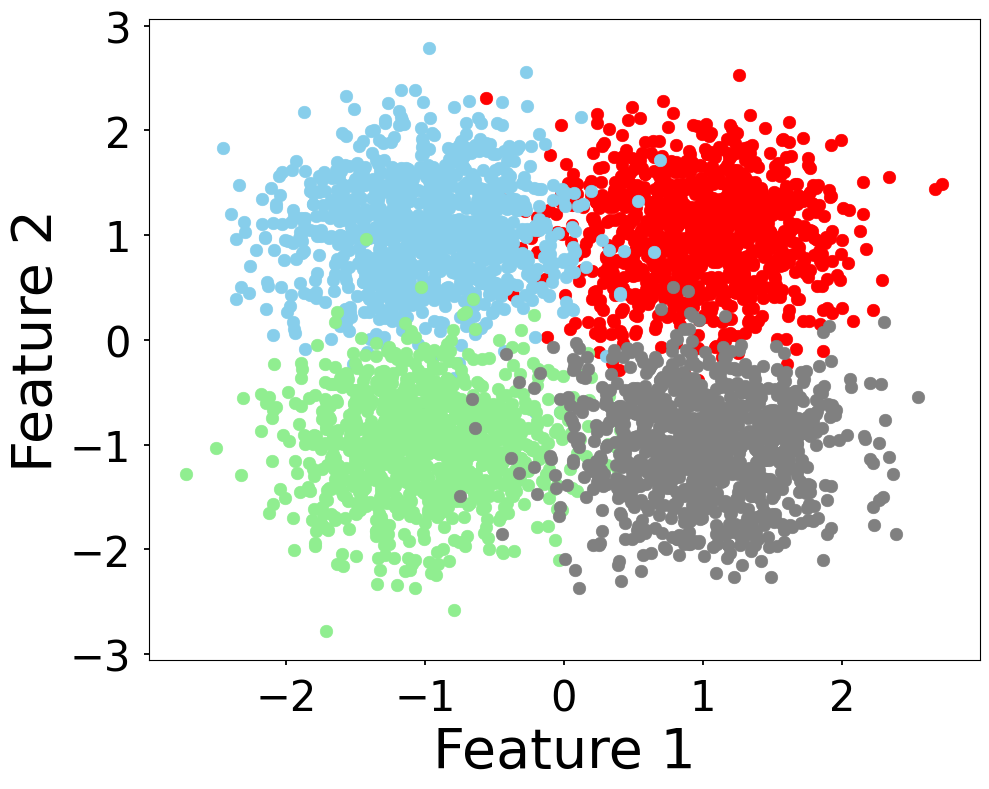

----------------------------------------
Training
----------------------------------------


100%|██████████| 20/20 [00:01<00:00, 18.40it/s]


Epoch 1: Train Loss 0.0004 Test Loss 0.0002 Test Acc 93.12


100%|██████████| 20/20 [00:01<00:00, 19.97it/s]


Epoch 2: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.70


100%|██████████| 20/20 [00:01<00:00, 13.29it/s]


Epoch 3: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.60


100%|██████████| 20/20 [00:01<00:00, 13.23it/s]


Epoch 4: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.72


100%|██████████| 20/20 [00:00<00:00, 20.04it/s]


Epoch 5: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.72


100%|██████████| 20/20 [00:00<00:00, 20.34it/s]


Epoch 6: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.85


100%|██████████| 20/20 [00:00<00:00, 20.65it/s]


Epoch 7: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.78


100%|██████████| 20/20 [00:00<00:00, 20.29it/s]


Epoch 8: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.85


100%|██████████| 20/20 [00:00<00:00, 20.30it/s]


Epoch 9: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.75


100%|██████████| 20/20 [00:01<00:00, 19.67it/s]


Epoch 10: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.72
----------------------------------------
Test Baseline- retain acc 95.83 forget acc 95.40 metric 0.0441
----------------------------------------


<ipython-input-16-d7c01dbc9d93>:177: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-talk")


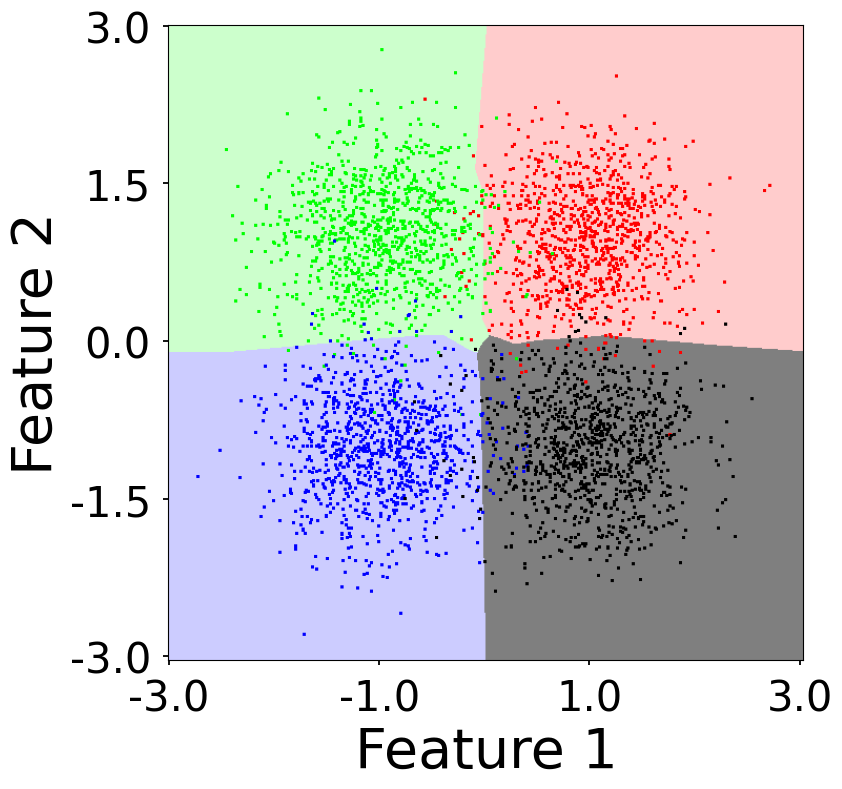

----------------------------------------
Retrain
----------------------------------------


100%|██████████| 15/15 [00:00<00:00, 27.20it/s]


Epoch 1: Train Loss 0.0004 Test Loss 0.0005 Test Acc 92.90


100%|██████████| 15/15 [00:00<00:00, 25.81it/s]


Epoch 2: Train Loss 0.0001 Test Loss 0.0001 Test Acc 97.10


100%|██████████| 15/15 [00:00<00:00, 25.34it/s]


Epoch 3: Train Loss 0.0001 Test Loss 0.0001 Test Acc 97.37


100%|██████████| 15/15 [00:00<00:00, 21.55it/s]


Epoch 4: Train Loss 0.0001 Test Loss 0.0001 Test Acc 97.30


100%|██████████| 15/15 [00:00<00:00, 17.38it/s]


Epoch 5: Train Loss 0.0001 Test Loss 0.0001 Test Acc 97.33


100%|██████████| 15/15 [00:00<00:00, 16.08it/s]


Epoch 6: Train Loss 0.0001 Test Loss 0.0001 Test Acc 97.43


100%|██████████| 15/15 [00:00<00:00, 20.58it/s]


Epoch 7: Train Loss 0.0001 Test Loss 0.0001 Test Acc 97.43


100%|██████████| 15/15 [00:00<00:00, 27.10it/s]


Epoch 8: Train Loss 0.0001 Test Loss 0.0001 Test Acc 97.37


100%|██████████| 15/15 [00:00<00:00, 26.66it/s]


Epoch 9: Train Loss 0.0001 Test Loss 0.0001 Test Acc 97.37


100%|██████████| 15/15 [00:00<00:00, 25.93it/s]


Epoch 10: Train Loss 0.0001 Test Loss 0.0001 Test Acc 97.37
----------------------------------------
Test Retained- retain acc 97.37 forget acc 0.00 metric 0.9737
----------------------------------------


<ipython-input-16-d7c01dbc9d93>:177: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-talk")


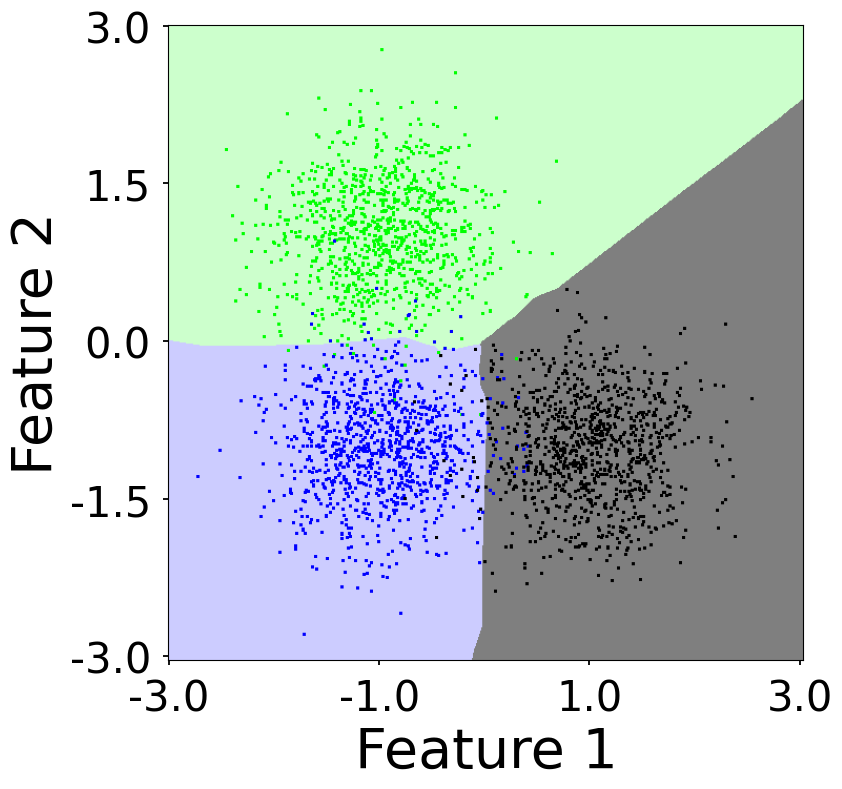

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [16]:
import torch
from torch import nn
from torch.nn import functional as F
from collections import OrderedDict
from copy import deepcopy
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import random
from tqdm import tqdm
import seaborn as sns
import os

class Linear5(nn.Module):
    def __init__(self, in_feature=2, hidden_features=5, num_classes=4):
        super(Linear5, self).__init__()
        self.fc1 = nn.Linear(in_features=in_feature, out_features=hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
        self.bn2 = nn.BatchNorm1d(hidden_features)
        self.fc3 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
        self.bn3 = nn.BatchNorm1d(hidden_features)
        self.fc4 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
        self.bn4 = nn.BatchNorm1d(hidden_features)
        self.fc5 = nn.Linear(in_features=hidden_features, out_features=num_classes)

    def forward(self,x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        return F.log_softmax(self.fc5(x), 1)

    def get_activations(self, x):
        act = {"pre":OrderedDict(), "post":OrderedDict()}
        act["pre"]["fc1"] = deepcopy(x.clone().detach().cpu().numpy())
        x = self.fc1(x)
        act["post"]["fc1"] = deepcopy(x.clone().detach().cpu().numpy())
        x = F.relu(self.bn1(x))
        act["pre"]["fc2"] = deepcopy(x.clone().detach().cpu().numpy())
        x = self.fc2(x)
        act["post"]["fc2"] = deepcopy(x.clone().detach().cpu().numpy())
        x = F.relu(self.bn2(x))
        act["pre"]["fc3"] = deepcopy(x.clone().detach().cpu().numpy())
        x = self.fc3(x)
        act["post"]["fc3"] = deepcopy(x.clone().detach().cpu().numpy())
        x = F.relu(self.bn3(x))
        act["pre"]["fc4"] = deepcopy(x.clone().detach().cpu().numpy())
        x = self.fc4(x)
        act["post"]["fc4"] = deepcopy(x.clone().detach().cpu().numpy())
        x = F.relu(self.bn4(x))
        act["pre"]["fc5"] = deepcopy(x.clone().detach().cpu().numpy())
        x = self.fc5(x)
        act["post"]["fc5"] = deepcopy(x.clone().detach().cpu().numpy())
        return act

    def project_weights(self, projection_mat_dict):
        self.fc1.weight.data = torch.mm(projection_mat_dict["post"]["fc1"].transpose(0,1), torch.mm(self.fc1.weight.data, projection_mat_dict["pre"]["fc1"].transpose(0,1)))
        self.fc1.bias.data = torch.mm(self.fc1.bias.data.unsqueeze(0), projection_mat_dict["post"]["fc1"]).squeeze(0)

        self.fc2.weight.data = torch.mm(projection_mat_dict["post"]["fc2"].transpose(0,1), torch.mm(self.fc2.weight.data, projection_mat_dict["pre"]["fc2"].transpose(0,1)))
        self.fc2.bias.data = torch.mm(self.fc2.bias.data.unsqueeze(0), projection_mat_dict["post"]["fc2"]).squeeze(0)

        self.fc3.weight.data = torch.mm(projection_mat_dict["post"]["fc3"].transpose(0,1), torch.mm(self.fc3.weight.data, projection_mat_dict["pre"]["fc3"].transpose(0,1)))
        self.fc3.bias.data = torch.mm(self.fc3.bias.data.unsqueeze(0), projection_mat_dict["post"]["fc3"]).squeeze(0)

        self.fc4.weight.data = torch.mm(projection_mat_dict["post"]["fc4"].transpose(0,1), torch.mm(self.fc4.weight.data, projection_mat_dict["pre"]["fc4"].transpose(0,1)))
        self.fc4.bias.data = torch.mm(self.fc4.bias.data.unsqueeze(0), projection_mat_dict["post"]["fc4"]).squeeze(0)

        self.fc5.weight.data =  torch.mm(self.fc5.weight.data, projection_mat_dict["pre"]["fc5"].transpose(0,1))
        return

def get_dataset(train_samples_per_class, test_samples_per_class, std = 0.5):
    print("-"*40)
    print("Generating Dataset")
    print("-"*40)
    means = [(1.0,1.0),(-1.0,1.0), (-1.0,-1.0), (1.0,-1.0) ]
    std_dev = (std,std)
    data_list = []
    target_list = []
    for classes in range(4):
        for sample in tqdm(range(train_samples_per_class), desc=f"Train class {classes}"):
            data_list.append(torch.normal(mean= torch.tensor(means[classes]), std= torch.tensor(std_dev) ))
            target_list.append(torch.tensor(classes).long())
    data_tensor = torch.stack(data_list, 0)
    target_tensor = torch.stack(target_list, 0)
    train_data = (data_tensor, target_tensor)

    data_list = []
    target_list = []
    for classes in range(4):
        for sample in tqdm(range(test_samples_per_class), desc=f"Test class {classes}"):
            data_list.append(torch.normal(mean= torch.tensor(means[classes]), std= torch.tensor(std) ))
            target_list.append(torch.tensor(classes).long())
    data_tensor = torch.stack(data_list, 0)
    target_tensor = torch.stack(target_list, 0)
    test_data = (data_tensor, target_tensor)
    return train_data, test_data

def train(model, train_loader, device, optimizer, schedular):
    model.train()
    total_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        log_prob = model(data)
        loss = F.nll_loss(log_prob, target)
        total_loss+= loss.detach().item()/len(train_loader.dataset)
        loss.backward()
        optimizer.step()
        schedular.step(loss)
    return total_loss


def test(model, test_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        log_prob = model(data)
        pred = log_prob.argmax(dim=1, keepdim=True)
        loss = F.nll_loss(log_prob, target)
        total_loss+= loss.detach().item()/len(test_loader.dataset)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = 100*correct/len(test_loader.dataset)
    return total_loss, acc

def plot_decision_boundary(model, data, device, title):
    data_list = []
    # x_points = np.arange(-4,4.04,0.05)
    # y_points = np.arange(4,-4.04,-0.05)
    x_points = np.arange(-3,3.04,0.01)
    y_points = np.arange(3,-3.04,-0.01)
    for x in x_points:
        for y in y_points:
            data_list.append(torch.tensor( (x,y) ) )
    data_tensor = torch.stack(data_list).to(device).float()
    predicted_class = model(data_tensor).argmax(dim=1).long()

    # color_lookup = [torch.tensor([1.0, 0.0, 0.0]).to(device),
    #                 torch.tensor([0.5294, 0.8078, 0.9216]).to(device),
    #                 torch.tensor([0.5647, 0.9333, 0.5647]).to(device),
    #                 torch.tensor([0.5, 0.5, 0.5]).to(device)]


    color_lookup = [torch.tensor([1.0, 0.8, 0.8]).to(device), # light
                    torch.tensor([0.8, 1.0, 0.8]).to(device), # light
                    torch.tensor([0.8, 0.8, 1.0]).to(device), # light
                    torch.tensor([0.5, 0.5, 0.5]).to(device), # light
                    torch.tensor([1.0, 0.0, 0.0]).to(device),
                    torch.tensor([0.0, 1.0, 0.0]).to(device),
                    torch.tensor([0.0, 0.0, 1.0]).to(device),
                    torch.tensor([0.0, 0.0, 0.0]).to(device),
                    ]
    ind = 0
    decision_boundary = torch.zeros( (3, x_points.shape[0], y_points.shape[0])).to(device)
    for x, _ in enumerate(x_points):
        for y, _ in enumerate(y_points):
            decision_boundary[:, x, y ] = color_lookup[predicted_class[ind]]
            ind+=1

    # draw circles.
    for i in range(data[0].shape[0]):
        x = data[0][i]
        y = data[1][i]
        x_i = np.round(x[0]/0.01).long()+300
        y_i = 601 - (np.round(x[1]/0.01).long()+300) # top left is  0 0  for image!
        for j in range(x_i-1, x_i+2):### To increase boldness
            for k in range(y_i-1, y_i+2):
                if j<=601 and k<=601:
                    decision_boundary[:, j, k] =  color_lookup[4+y]

    decision_boundary = (255 * decision_boundary).long().permute(2,1,0).cpu().numpy().astype(np.uint8)
    fig,ax = plt.subplots()
    fig.set_size_inches(10,8)
    plt.style.use("seaborn-talk")
    cs = sns.color_palette("muted")

    plt.imshow( decision_boundary)
    x_ticks_positions = np.arange(0, x_points.shape[0]+0.5, 200)
    x_ticks_labels = [str(x) for x in np.arange(-3,3.04,2.0)]
    plt.xticks(x_ticks_positions, x_ticks_labels, fontsize=30)
    y_ticks_positions = np.arange(0, y_points.shape[0]+0.5, 150 )
    y_ticks_labels = [str(x) for x in np.arange(3,-3.04,-1.5)]
    plt.yticks(y_ticks_positions, y_ticks_labels, fontsize=30)
    plt.xlabel("Feature 1", fontsize=40)
    plt.ylabel("Feature 2", fontsize=40)
    # plt.title(title)
    # plt.xticks()
    # plt.yticks(fontsize=30)
    plt.tight_layout()
    plt.savefig(f"./images/demo_{title.split(':')[0].lower()}.pdf")
    plt.show()
    return


def main():
    # Some variables
    seed=42
    std = 0.5
    epochs = 10
    train_samples_per_class = 10000
    test_samples_per_class = 1000
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if not os.path.exists("./images"):
        os.makedirs("./images")
    # torch.use_deterministic_algorithms(True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data1, data2 = get_dataset(train_samples_per_class, test_samples_per_class, std = std)
    kwargs = {
        'batch_size': 2048,
        'num_workers': 1,
        'pin_memory': True,
        'shuffle': True
    }
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data1[0], data1[1]),**kwargs)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data2[0], data2[1]), **kwargs)
    retain_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data1[0][train_samples_per_class:], data1[1][train_samples_per_class:]),**kwargs)
    forget_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data1[0][:train_samples_per_class], data1[1][:train_samples_per_class]),**kwargs)
    test_retain_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data2[0][test_samples_per_class:], data2[1][test_samples_per_class:]),**kwargs)
    test_forget_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data2[0][:test_samples_per_class], data2[1][:test_samples_per_class]),**kwargs)


    # Plot data
    def lighten_color(color, amount=0.5):
        """
        Lightens the given color by multiplying (1-luminosity) by the given amount.
        Input can be matplotlib color string, hex string, or RGB tuple.

        Examples:
        >> lighten_color('g', 0.3)
        >> lighten_color('#F034A3', 0.6)
        >> lighten_color((.3,.55,.1), 0.5)
        """
        import matplotlib.colors as mc
        import colorsys
        try:
            c = mc.cnames[color]
        except:
            c = color
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    fig,ax = plt.subplots()
    fig.set_size_inches(10,8)
    plt.style.use("seaborn-talk")
    cs = sns.color_palette("muted")
    # plt.imshow( decision_boundary)
    plt.scatter(data2[0][:test_samples_per_class,0], data2[0][:test_samples_per_class,1],color= lighten_color("r",1.0),label="Class 1")
    plt.scatter(data2[0][test_samples_per_class:2*test_samples_per_class,0], data2[0][test_samples_per_class:2*test_samples_per_class,1], color= lighten_color("skyblue",1.0),label="Class 2")
    plt.scatter(data2[0][2*test_samples_per_class:3*test_samples_per_class,0],  data2[0][2*test_samples_per_class:3*test_samples_per_class,1], color= lighten_color("lightgreen",1.0),label="Class 3")
    plt.scatter(data2[0][3*test_samples_per_class:,0],  data2[0][3*test_samples_per_class:,1], color= "gray",label="Class 4")
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel("Feature 1", fontsize=40)
    plt.ylabel("Feature 2", fontsize=40)
    # plt.legend( fontsize=25)
    plt.tight_layout()
    plt.savefig(f"./images/demo_data.pdf")
    plt.show()

    print("-"*40)
    print("Training")
    print("-"*40)
    model = Linear5().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, nesterov=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.7)
    for epoch in range(1, epochs+1):
        train_loss = train(model, train_loader, device, optimizer, scheduler)
        test_loss, test_acc = test(model, test_loader, device)
        print(f"Epoch {epoch}: Train Loss {train_loss:.4f} Test Loss {test_loss:.4f} Test Acc {test_acc:.2f}")
    test_retain_loss, test_retain_acc = test(model, test_retain_loader, device)
    test_forget_loss, test_forget_acc = test(model, test_forget_loader, device)
    test_metric = test_retain_acc*(100-test_forget_acc)/10000
    print("-"*40)
    print(f"Test Baseline- retain acc {test_retain_acc:.2f} forget acc {test_forget_acc:.2f} metric {test_metric:.4f}")
    print("-"*40)
    plot_decision_boundary(model, data2, device, title = f"Baseline: Retain acc-{test_retain_acc:.2f} Forget Acc-{test_forget_acc:.2f}" )

    print("-"*40)
    print("Retrain")
    print("-"*40)
    retrained_model = Linear5().to(device)
    optimizer = torch.optim.SGD(retrained_model.parameters(), lr = 0.1, momentum=0.9, nesterov=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.7)
    for epoch in range(1, epochs+1):
        train_loss = train(retrained_model, retain_loader, device, optimizer, scheduler)
        test_loss, test_acc = test(retrained_model, test_retain_loader, device)
        print(f"Epoch {epoch}: Train Loss {train_loss:.4f} Test Loss {test_loss:.4f} Test Acc {test_acc:.2f}")
    test_retain_loss, test_retain_acc = test(retrained_model, test_retain_loader, device)
    test_forget_loss, test_forget_acc = test(retrained_model, test_forget_loader, device)
    test_metric = test_retain_acc*(100-test_forget_acc)/10000
    print("-"*40)
    print(f"Test Retained- retain acc {test_retain_acc:.2f} forget acc {test_forget_acc:.2f} metric {test_metric:.4f}")
    print("-"*40)
    plot_decision_boundary(retrained_model, (data2[0][test_samples_per_class:], data2[1][test_samples_per_class:]), device, title = f"Retrained: Retain acc-{test_retain_acc:.2f} Forget Acc-{test_forget_acc:.2f}" )




    retain_data = data1[0][train_samples_per_class:]
    model.eval()
    retain_act = model.get_activations(retain_data.to(device))
    retain_mat_dict= {"pre":OrderedDict(), "post":OrderedDict()}
    retain_normalize_var_mat_dict = {"pre":OrderedDict(), "post":OrderedDict()}
    # Compute Ur
    for loc in retain_act.keys():
        for key in retain_act[loc].keys():
            activation = torch.Tensor(retain_act[loc][key]).to("cuda").transpose(0,1)
            U,S,Vh = torch.linalg.svd(activation, full_matrices=False)
            U = U.cpu().numpy()
            S = S.cpu().numpy()
            retain_mat_dict[loc][key] = U
            retain_normalize_var_mat_dict[loc][key] = S**2 / (S**2).sum()

    forget_data = data1[0][:train_samples_per_class]
    forget_act = model.get_activations(forget_data.to(device))
    forget_mat_dict= {"pre":OrderedDict(), "post":OrderedDict()}
    forget_normalize_var_mat_dict = {"pre":OrderedDict(), "post":OrderedDict()}
    # Compute Uf
    for loc in forget_act.keys():
        for key in forget_act[loc].keys():
            activation = torch.Tensor(forget_act[loc][key]).to("cuda").transpose(0,1)
            U,S,Vh = torch.linalg.svd(activation, full_matrices=False)
            U = U.cpu().numpy()
            S = S.cpu().numpy()
            forget_mat_dict[loc][key] = U
            forget_normalize_var_mat_dict[loc][key] = S**2 / (S**2).sum()

    print("-"*40)
    print("Forgetting Search for best alpha_f and alpha_r on Train Set.")
    print("-"*40)
    base_retain_loss, base_retain_acc = test(model, retain_loader, device)
    base_forget_loss, base_forget_acc = test(model, forget_loader, device)
    base_metric = base_retain_acc*(100-base_forget_acc)/10000
    print(f"Train Baseline - retain acc {base_retain_acc:.2f} forget acc {base_forget_acc:.2f} metric {base_metric:.4f}")
    best_alpha_r = 1.0
    best_alpha_f = 0.25
    best_metric = base_metric
    proj_mat_dict= {"pre":OrderedDict(), "post":OrderedDict()}
    for alpha_r in [1, 3, 10, 30, 100, 300, 1000]:
        for alpha_f in [0.25, 0.5, 0.9, 1, 3, 10, 30, 100, 300, 1000]:
            for loc in retain_act.keys():
                for key in retain_act[loc].keys():
                    sqrt_imp_r = torch.diag(torch.tensor( (alpha_r*retain_normalize_var_mat_dict[loc][key]/(( (alpha_r-1)*retain_normalize_var_mat_dict[loc][key]) +1))**0.5).to(device))
                    Ur = torch.tensor(retain_mat_dict[loc][key]).to(device)
                    Ur = torch.mm(Ur, sqrt_imp_r)
                    Mr = torch.mm(Ur, Ur.transpose(0,1))
                    sqrt_imp_f = torch.diag(torch.tensor( (alpha_f*forget_normalize_var_mat_dict[loc][key]/(( (alpha_f-1)*forget_normalize_var_mat_dict[loc][key]) +1))**0.5).to(device))
                    Uf = torch.tensor(forget_mat_dict[loc][key]).to(device)
                    Uf = torch.mm(Uf, sqrt_imp_f)
                    Mf = torch.mm(Uf, Uf.transpose(0,1))
                    I = torch.eye(Mf.shape[0]).to(device)
                    if loc == "pre":
                        proj_mat_dict[loc][key]= I - Mf  + torch.mm(Mf, Mr)
                    else:
                        proj_mat_dict[loc][key]= I
            inference_model = deepcopy(model)
            inference_model.project_weights(proj_mat_dict)
            retain_loss, retain_acc = test(inference_model, retain_loader, device)
            forget_loss, forget_acc = test(inference_model, forget_loader, device)
            metric = retain_acc*(100-forget_acc)/10000
            if metric>best_metric:
                best_metric = metric
                best_alpha_r = alpha_r
                best_alpha_f = alpha_f
                print(f"Current Search - retain acc {retain_acc:.2f} forget acc {forget_acc:.2f} metric {best_metric:.4f} alpha_r {best_alpha_r} alpha_f {best_alpha_f} ")


    # Plot decision boundary for best model
    for loc in retain_act.keys():
        for key in retain_act[loc].keys():
            sqrt_imp_r = torch.diag(torch.tensor( (best_alpha_r*retain_normalize_var_mat_dict[loc][key]/(( (best_alpha_r-1)*retain_normalize_var_mat_dict[loc][key]) +1))**0.5).to(device))
            Ur = torch.tensor(retain_mat_dict[loc][key]).to(device)
            Ur = torch.mm(Ur, sqrt_imp_r)
            Mr = torch.mm(Ur, Ur.transpose(0,1))
            sqrt_imp_f = torch.diag(torch.tensor( (best_alpha_f*forget_normalize_var_mat_dict[loc][key]/(( (best_alpha_f-1)*forget_normalize_var_mat_dict[loc][key]) +1))**0.5).to(device))
            Uf = torch.tensor(forget_mat_dict[loc][key]).to(device)
            Uf = torch.mm(Uf, sqrt_imp_f)
            Mf = torch.mm(Uf, Uf.transpose(0,1))
            I = torch.eye(Mf.shape[0]).to(device)
            if loc == "pre":
                proj_mat_dict[loc][key]= I - Mf + torch.mm(Mf, Mr)
            else:
                proj_mat_dict[loc][key]= I

    inference_model = deepcopy(model)
    inference_model.project_weights(proj_mat_dict)
    test_retain_loss, test_retain_acc = test(inference_model, test_retain_loader, device)
    test_forget_loss, test_forget_acc = test(inference_model, test_forget_loader, device)
    test_metric = test_retain_acc*(100-test_forget_acc)/10000
    print(f"Test Unlearnt- retain acc {test_retain_acc:.2f} forget acc {test_forget_acc:.2f} metric {test_metric:.4f}")
    print("-"*40)
    plot_decision_boundary(inference_model, (data2[0][test_samples_per_class:], data2[1][test_samples_per_class:]), device, title = f"Unlearnt: Retain acc-{test_retain_acc:.2f} Forget Acc-{test_forget_acc:.2f}" )



if __name__ == '__main__':
    main()


